In [2]:
import numpy as np
import deepxde as dde
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
save_folder = "./visualization/"
n = np.array([[1, 1], [1, 2], [2, 1], [2, 2]])
dde.config.set_default_float("float64")

Set the default float type to float64


In [4]:
def plot_2d(x, y, solution, title):
    plt.scatter(x, y, c=solution, cmap='viridis')
    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    # Add a colorbar
    plt.colorbar()
    # Show the plot
    plt.show()
    plt.savefig(save_folder + title)
    plt.close()

def contour_plot(X, Y, Z, title):
    plt.style.use('_mpl-gallery-nogrid')
    levels = np.linspace(np.min(Z), np.max(Z), 25)
    # plot
    fig, ax = plt.subplots()
    ax.plot(X, Y, 'o', markersize=2, color='lightgrey')
    ax.tricontour(X, Y, Z, levels=levels)

    ax.set(xlim=(-3, 3), ylim=(-3, 3))

    plt.show()
    plt.savefig(save_folder + title)
    plt.close()

In [5]:
def exact_sol(f):
    x = f[:, 0:1]
    y = f[:, 1:2]
    n1 = f[:, 2:3]
    n2 = f[:, 3:4]
    return np.sin(n1*np.pi*(x + 1)*0.5)*np.sin(n2*np.pi*(y + 1)*0.5)

def exact_sol_single(x, y):
    return np.sin(n1*np.pi*(x + 1)*0.5)*np.sin(n2*np.pi*(y + 1)*0.5)

In [6]:
def pde(netw_in, netw_out):
    dy_xx = dde.grad.hessian(netw_out, netw_in, i=0, j=0)
    dy_yy = dde.grad.hessian(netw_out, netw_in, i=1, j=1)
    n1 = torch.round(netw_in[:,2:3])
    n2 = torch.round(netw_in[:,3:4])
    return 0.5*(dy_xx + dy_yy)+(n1**2+n2**2)*(np.pi**2)*netw_out/8

def transform(x, y):
    result = (1 + x[:, 0:1]) * (1-x[:, 0:1]) * (1 + x[:, 1:2]) * (1-x[:, 1:2])
    return result * y

def boundary(_, on_boundary):
    return on_boundary

Compiling model...
'compile' took 0.000608 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [4.38e-01, 1.06e-02]    [4.38e-01, 1.06e-02]    [1.10e+00]    
1000      [4.42e-05, 2.06e-06]    [4.42e-05, 2.06e-06]    [1.00e+00]    
2000      [1.34e-05, 6.93e-07]    [1.34e-05, 6.93e-07]    [1.00e+00]    
3000      [6.58e-06, 3.70e-07]    [6.58e-06, 3.70e-07]    [1.00e+00]    
4000      [3.70e-06, 1.93e-07]    [3.70e-06, 1.93e-07]    [1.00e+00]    
5000      [2.17e-06, 1.04e-07]    [2.17e-06, 1.04e-07]    [1.00e+00]    
6000      [1.41e-06, 6.03e-08]    [1.41e-06, 6.03e-08]    [1.00e+00]    
7000      [9.59e-07, 4.79e-08]    [9.59e-07, 4.79e-08]    [1.00e+00]    
8000      [6.69e-07, 3.58e-08]    [6.69e-07, 3.58e-08]    [1.00e+00]    
9000      [5.11e-07, 4.12e-08]    [5.11e-07, 4.12e-08]    [1.00e+00]    
10000     [3.79e-07, 3.54e-08]    [3.79e-07, 3.54e-08]    [1.00e+00]    
11000     [3.40e-07, 4.69e-08]    [3.40e-07, 4.69e-08]    [

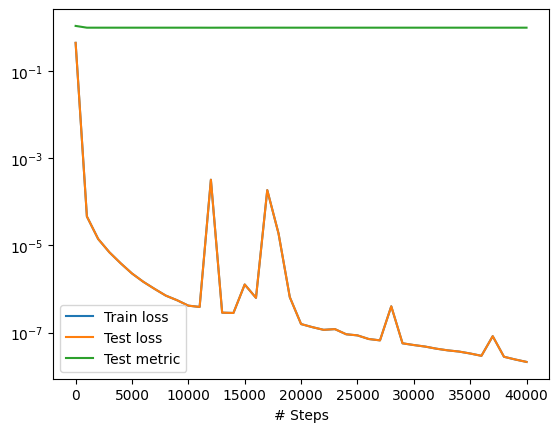

In [12]:
geom = dde.geometry.Hypercube([-1, -1, 1, 1], [1, 1, 2, 2])
bc = dde.icbc.DirichletBC(geom, lambda _: 0, boundary)

data = dde.data.PDE(
    geom, 
    pde, 
    bc, 
    num_domain = 800,
    num_boundary = 100,
    solution=exact_sol,
)
layer_size = [4] + [32] * 4 + [1]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)

net.apply_output_transform(transform)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

losshistory, train_state = model.train(iterations=5000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [8]:
def generate_test_data(size):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    test_x, test_y = np.meshgrid(x, y)
    test_x = test_x.reshape(-1)
    test_y = test_y.reshape(-1)
    test_domain = np.array([
        data_for_n(test_x, test_y, [1, 1]),
        data_for_n(test_x, test_y, [1, 2]),
        data_for_n(test_x, test_y, [2, 1]),
        data_for_n(test_x, test_y, [2, 2])]
    )
    return test_domain

def data_for_n(x, y, n):
    n1 = np.repeat(n[0], len(x))
    n2 = np.repeat(n[1], len(x))
    return np.vstack((x, y, n1, n2)).T

In [9]:
def get_solution(data):
    solution = np.hstack([model.predict(el) for el in data])
    print("sol",solution)
    return solution

In [10]:
def graph_shreodinger(input_data, output_data, title):
    fig, ax = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(10, 10)
    fig.suptitle(title)
    for i in range(len(n)):
        n1 = n[i][0] - 1
        n2 = n[i][1] - 1
        contour = ax[n1][n2].tricontour(input_data[i,:,0], input_data[i,:,1], output_data[:, i])
        ax[n1][n2].clabel(contour, inline=1, fontsize=10)

sol [[-0. -0.  0. -0.]
 [-0. -0.  0. -0.]
 [-0. -0.  0. -0.]
 ...
 [ 0. -0.  0. -0.]
 [ 0. -0.  0. -0.]
 [ 0. -0.  0. -0.]]


/tmp/ipykernel_308/3777939649.py:8: RuntimeWarning: invalid value encountered in divide
  error_l2 = (np.abs(predicted_solution - exact_solution)/exact_solution)**2


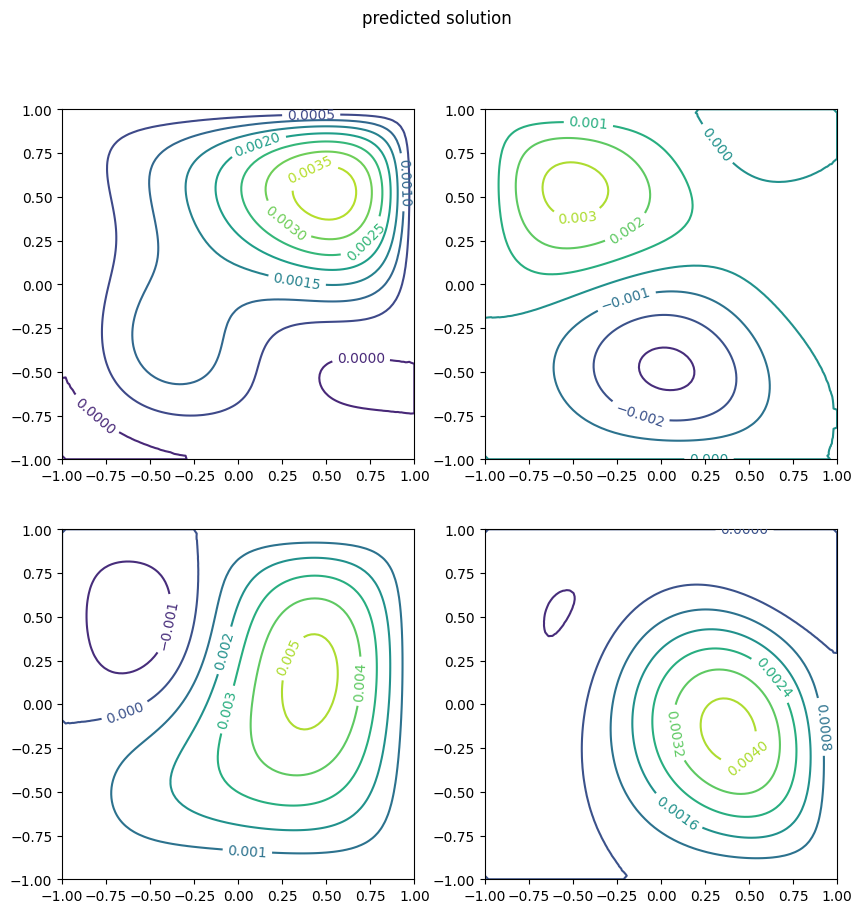

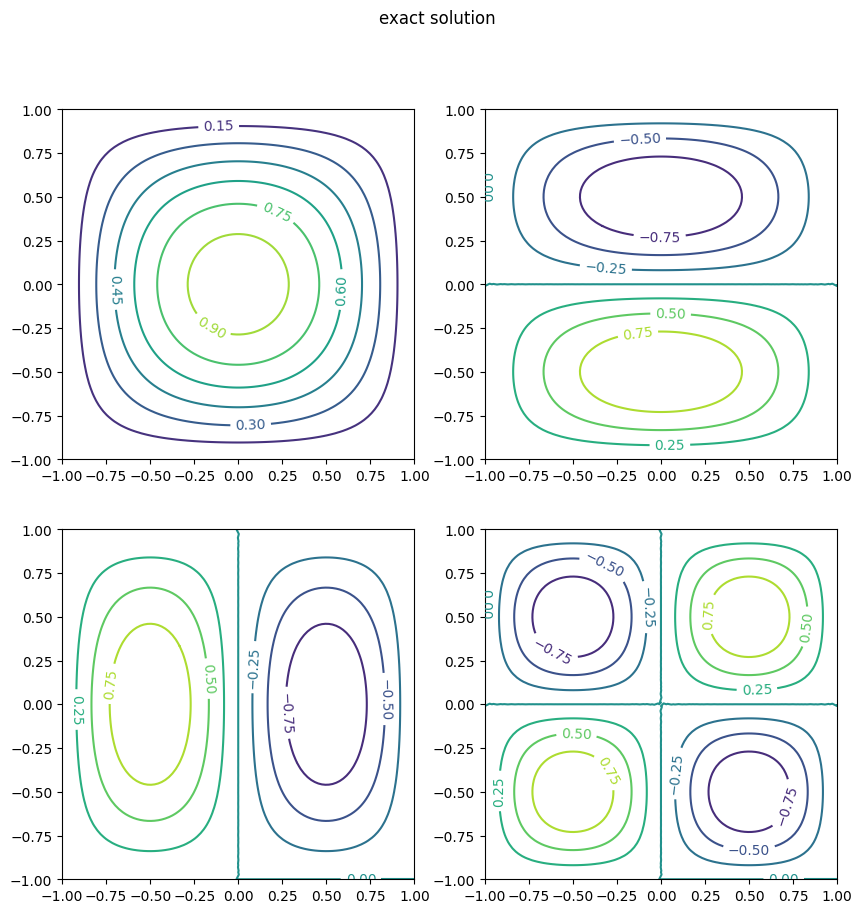

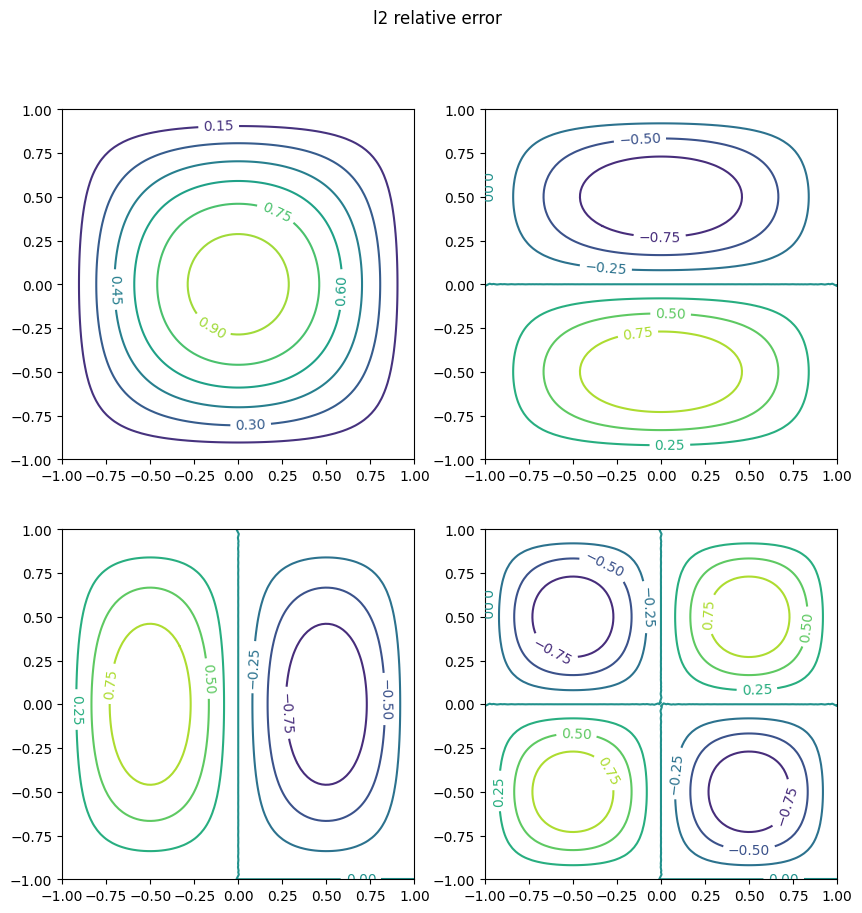

In [11]:
test_domain = generate_test_data(100)
predicted_solution = get_solution(test_domain)
graph_shreodinger(test_domain, predicted_solution, "predicted solution")

exact_solution = np.hstack([exact_sol(el) for el in test_domain])
graph_shreodinger(test_domain, exact_solution, "exact solution")

error_l2 = (np.abs(predicted_solution - exact_solution)/exact_solution)**2
graph_shreodinger(test_domain, exact_solution, "l2 relative error")